# COUNTERFACTUALS GUIDED BY PROTOTYPES ON FASHION MNIST





The counterfactuals guided by prototypes method works on black-box models. In the context of predictive models, a counterfactual instance describes the necessary change in input features of a test instance that alter the prediction to a predefined output (e.g. a prediction class). 

It can use both an encoder or k-d trees to define the prototypes.This method can speed up the search, especially for black box models, and create interpretable counterfactuals. This is because only the prototypes (which are less in number) are used for finding out the counterfactuals.


In [1]:
!pip install alibi

     |████████████████████████████████| 225kB 8.2MB/s 
     |████████████████████████████████| 327kB 9.4MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 204kB 19.0MB/s 
     |████████████████████████████████| 28.0MB 148kB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456462 sha256=38fd47ababf0281381df8ddda15256a46d7702ee7620ad8cf7f6f181d99d3935
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.1.0-py2.py3-none-any.whl size=28052144 sha256=ee09299db9ec7af322b41a3cd02b69709d5be2c29063577d9034878e7559e457
  Stored in directory: /root/.cache/pip/wheels/2a/2b/0a/d6fb6235c56d014d224bca760d15d7cbdd820813085ffcd35d
Successfully built shap spacy-lookups-data


In [2]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import CounterFactualProto

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.3.0
Eager execution enabled:  False


Loading the data :

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)

4423680/4422102 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28) y_train shape: (60000,)


In [4]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [5]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

Defining and training the CNN model :

In [6]:
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)

    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

In [7]:
cnn = cnn_model()
cnn.fit(x_train, y_train, batch_size=32, epochs=3, verbose=0)
cnn.save('fashion_mnist_cnn.h5', save_format='h5')

In [8]:
cnn = load_model('fashion_mnist_cnn.h5')
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Test accuracy:  0.8937


Since the accuracy is good, the model is good.

Defining and training the auto-encoder :

In [9]:
def ae_model():
    # encoder
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    encoder = Model(x_in, encoded)

    # decoder
    dec_in = Input(shape=(14, 14, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(dec_in)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    decoder = Model(dec_in, decoded)

    # autoencoder = encoder + decoder
    x_out = decoder(encoder(x_in))
    autoencoder = Model(x_in, x_out)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder, decoder

In [10]:
ae, enc, dec = ae_model()
ae.fit(x_train, x_train, batch_size=128, epochs=4, validation_data=(x_test, x_test), verbose=0)
ae.save('fashion_mnist_ae.h5', save_format='h5')
enc.save('fashion_mnist_enc.h5', save_format='h5')

Generating counterfactual guided by the nearest class prototype 

Original instance :

Prediction on instance to be explained: [4]
Prediction probabilities for each class on the instance: [[1.4624259e-04 5.2487962e-05 7.0026033e-02 3.6525274e-05 8.9095360e-01
  3.1313027e-06 3.8744565e-02 1.2405181e-07 3.1318508e-05 5.9230056e-06]]


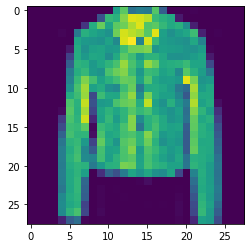

In [37]:
X = x_test[10].reshape((1,) + x_test[10].shape)
plt.imshow(X.reshape(28, 28));
print('Prediction on instance to be explained: {}'.format([np.argmax(cnn.predict(X))]))
print('Prediction probabilities for each class on the instance: {}'.format(cnn.predict(X)))

The original instance has the target class 4 which represents coat.

Counterfactual parameters :

In [38]:
shape = (1,) + x_train.shape[1:]
gamma = 100.
theta = 100.
c_init = 1.
c_steps = 2
max_iterations = 1000
feature_range = (x_train.min(),x_train.max())

In [39]:
# initialize explainer, fit and generate counterfactual
cf = CounterFactualProto(cnn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
start_time = time()
cf.fit(x_train)  # find class prototypes
print('Time to find prototypes each class: {:.3f} sec'.format(time() - start_time))
start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Time to find prototypes each class: 37.780 sec
Explanation took 16.466 sec


As shown, the time taken is quite large if autoencoder is used.

Results :

Counterfactual prediction: 2
Closest prototype class: 2


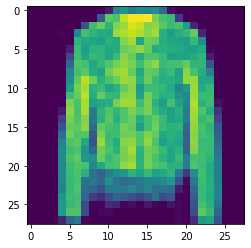

In [40]:
print('Counterfactual prediction: {}'.format(explanation.cf['class']))
print('Closest prototype class: {}'.format(explanation.id_proto))
plt.imshow(explanation.cf['X'].reshape(28, 28));

The nearest prorotype class is searched and found to be 2 i.e.  pullover, which can be expected as a coat is similar to pullover. The counterfactual preduction is same as the nearest prototype which implies that the counterfactual makes the features change to approach to the nearest prototype class successfully.

Now, instead of the nearest prototype class, we can also explicitly specify the target class in order to move the counterfactual to a specific prediction class.

Specify prototype classes

Prediction on instance to be explained: [5]


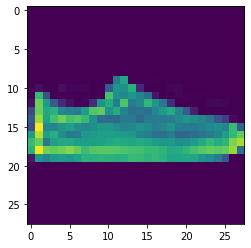

In [61]:
X = x_test[12].reshape((1,) + x_test[12].shape)
plt.imshow(X.reshape(28, 28));
print('Prediction on instance to be explained: {}'.format([np.argmax(cnn.predict(X))]))

We take an instance that is an image of a sandal.

In [62]:
# initialize explainer, fit and generate counterfactuals
cf = CounterFactualProto(cnn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)
explanation_1 = cf.explain(X, k=5, k_type='mean')
proto_1 = explanation_1.id_proto
explanation_2 = cf.explain(X, k=5, k_type='mean', target_class=[8])
proto_2 = explanation_2.id_proto

Counterfactual prediction: 7
Closest prototype class: 7


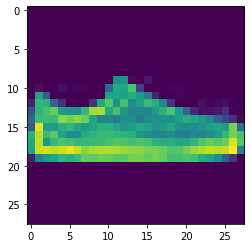

In [63]:
print('Counterfactual prediction: {}'.format(explanation_1.cf['class']))
print('Closest prototype class: {}'.format(proto_1))
plt.imshow(explanation_1.cf['X'].reshape(28, 28));

The nearest protype class is found by considering the mean of the data points and the nearest prototype is identified to be 7 that is image of sneaker. The above change takes place naturally when no target class is specified by us.

Counterfactual prediction: 8
Closest prototype class: 8


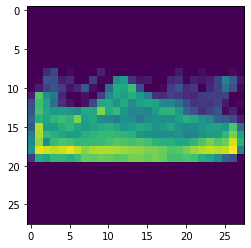

In [29]:
print('Counterfactual prediction: {}'.format(explanation_2.cf['class']))
print('Closest prototype class: {}'.format(proto_2))
plt.imshow(explanation_2.cf['X'].reshape(28, 28));

The shape of the sandal is made to look similar to a bag, which is the specified target class -8.

To speed up the process(which is one of the advantages of prototype counterfactual over counterfactual), the prediction loss term can be removed  as shown below: 

Prediction on instance to be explained: [2]


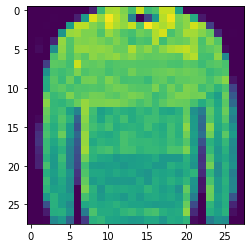

In [46]:
X = x_test[20].reshape(1, 28, 28, 1)
plt.imshow(X.reshape(28, 28));
print('Prediction on instance to be explained: {}'.format([np.argmax(cnn.predict(X))]))

The original prediction is class 2 which is an image of pullover.

In [47]:
c_init = 0. 
c_steps = 1  

The weight of prediction loss term is set to 0.

In [48]:
predict_fn = lambda x: cnn.predict(x)

# initialize explainer, fit and generate counterfactuals
cf = CounterFactualProto(predict_fn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)
start_time = time()
explanation = cf.explain(X, k=1)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 10.079 sec


Now much less time is taken for the explanation.

Counterfactual prediction: 6
Closest prototype class: 6


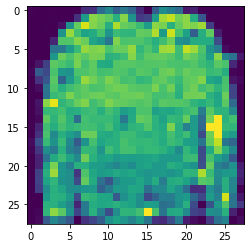

In [49]:
print('Counterfactual prediction: {}'.format(explanation.cf['class']))
print('Closest prototype class: {}'.format(explanation.id_proto))
plt.imshow(explanation.cf['X'].reshape(28, 28))

Now, here the nearest prorotype class is found to be 6 i.e.  shirt, which is very similar to the original prediction pullover. The changes to the pixels are made to the shirt to make it look like shirt and thus change the prediction to 6.